In [1]:
from tqdm import tqdm
import pandas as pd
tqdm.pandas(bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter

# modelling
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)

In [5]:
movies_final = pd.read_csv("data/movies_final.csv")

## ML Pipeline

### Train Validation Holdout Split

In [6]:
df = movies_final.copy()
df.fillna(0, inplace=True)
df_null = pd.isnull(df).sum()
columns_with_null = df_null[df_null > 0]
columns_with_null

Series([], dtype: int64)

In [7]:
X = df.drop(['highRated'], axis=1)
y = df['highRated']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)
display(y_trainval.value_counts())
display(y_holdout.value_counts())

highRated
0    130152
1      1049
Name: count, dtype: int64

highRated
0    43384
1      350
Name: count, dtype: int64

### Auto-ML

In [282]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):

        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        train_precision = []
        val_precision = []

        train_f1 = []
        val_f1 = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)

            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            # precision
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))

            # F1 score
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))
            
            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train f1': np.round(np.mean(train_f1) * 100, 2),
                'Val f1`': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train f1': np.round(np.mean(train_f1) * 100, 2),
                'Val f1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline Models

In [2]:
# general libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# modelling
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, f1_score)

# imbalanced techniques
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN

# interpretability
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model deployment
from flask import Flask
import streamlit as st


In [360]:
models_dict = {
               'RandomForestClassifier': RandomForestClassifier(random_state=143),
               'XGBoost': XGBClassifier(random_state=143),
}

### XGBoost (SMOTE Resampling + Hypertuning)

In [285]:
def train_xgb(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.1, 0.01, 0.001],
        "max_depth": [3, 5, 7],
        # "min_child_weight": [1, 3, 5],
        # "subsample": [0.6, 0.8, 1.0],
        # "colsample_bytree": [0.6, 0.8, 1.0]
    }
    new_params = {'xgbclassifier__' + key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(
            MinMaxScaler(),
            res_t,
            XGBClassifier(random_state=143, use_label_encoder=False)
        )
    else:
        imba_pipeline = make_pipeline(
            MinMaxScaler(),
            XGBClassifier(random_state=143, use_label_encoder=False)
        )

    if hypertune is True:
        clf = GridSearchCV(
            imba_pipeline, param_grid=new_params, 
            cv=skf, scoring=metric, return_train_score=True,
            verbose=10
        )
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['XGBoost Classifier', 
                np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 
                'Best parameters = {0}'.format(clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(
            estimator=clf, X=X, y=y, 
            scoring=metric, cv=skf, n_jobs=-1, 
            return_train_score=True
        )
        return ['XGBoost Classifier', 
                np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), 
                run_time, clf]

In [286]:
start_time = time.time()
rf_rec = train_xgb(X_trainval, y_trainval, 'recall', SMOTE(),
                       hypertune=True, resample=True)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50
[CV 1/5; 1/27] END xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=(train=0.988, test=0.981) total time=   1.2s
[CV 2/5; 1/27] START xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50
[CV 2/5; 1/27] END xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=(train=0.987, test=0.990) total time=   1.1s
[CV 3/5; 1/27] START xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50
[CV 3/5; 1/27] END xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=(train=0.988, test=0.986) total time=   1.1s
[CV 4/5; 1/27] START xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__n_e

In [368]:
rf_rec

['XGBoost Classifier',
 0.9829201955801083,
 0.9866575529733425,
 "Best parameters = {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 200}",
 421.79482078552246,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('smote', SMOTE()),
                 ('xgbclassifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.01,
                                max_bin=None, max_cat_threshold=None,
                              

In [367]:
# re-fitting for the holdout
rh = rf_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds_ = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds_)

In [289]:
# cross-validation
base_var = train_xgb(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)


holdout_score = recall_score(y_holdout, y_preds)

In [290]:
# cross-validation (resampling)
res_var = train_xgb(X_trainval, y_trainval, 'recall', hypertune=False, resample=True, res_t=SMOTE())

# re-fitting for the holdout
res_model = res_var[-1]
res_model.fit(X_trainval, y_trainval)
y_preds = res_model.predict(X_holdout)
res_holdout_score = recall_score(y_holdout, y_preds)

In [291]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]

summary.loc[1] = ['Resampling',
                 '{:.2f}%'.format(np.round(res_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(res_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(res_holdout_score*100, 2))]

summary.loc[2] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style

,Method,Train Recall,Val Recall,Holdout Recall
0,No Resampling,88.49%,42.42%,47.14%
1,Resampling,97.62%,74.26%,77.43%
2,Resampling x Hypertune,98.29%,98.67%,99.71%


### Results Summary
1. **Resampling with SMOTE + Hyperparameter Tuning** is the **best method for handling class imbalance**. It achieves the **highest recall scores** across train, validation, and holdout datasets with minimal overfitting.
2. **XGBoost** combined with **SMOTE** and **hyperparameter** optimization leverages the strengths of both advanced modeling and effective data balancing techniques.
3. The improvement from **74.26% (SMOTE) to 99.71% (SMOTE + Hyperparameter Tuning)** in holdout recall highlights the importance of fine-tuning parameters to achieve optimal performance.

### Confusion Matrix
- The model successfully captures almost all AAA titles, with a recall of ~99.7% (only 1 out of 350 actual AAA movies is missed). This means the model is very reliable at ensuring AAA titles are identified.
- The model predicts many non-AAA (low-rated) movies as AAA (1,187 false positives), leading to a precision of ~22.7% for high-rated movies. This implies that while most AAA titles are captured, the predictions include a significant number of false positives.

**Why High Recall Matters:**

In the context of predicting AAA movies, high recall is critical because failing to identify a potential AAA movie (false negatives) can lead to missed opportunities for marketing, investment, or further evaluation.
The model ensures that almost all high-rated movies are flagged, minimizing the risk of missing valuable AAA candidates.

**Trade-Off Between Precision and Recall:**

The current model prioritizes recall over precision, which is a justified trade-off for this task. Identifying all potential AAA movies is more important than having a small number of false positives.

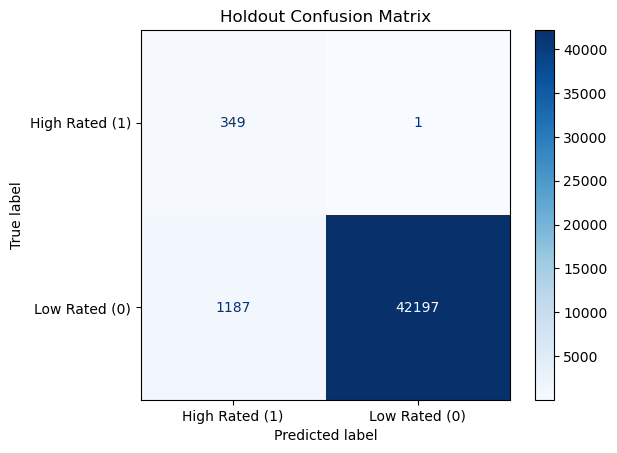

In [374]:
cm = confusion_matrix(y_holdout, y_preds_, labels=[1, 0])  # Adjust labels if needed

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["High Rated (1)", "Low Rated (0)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Holdout Confusion Matrix")
plt.show()

In [292]:
pickle.dump(rh, open('xgb.pkl', 'wb'))

In [3]:
model = pickle.load(open('xgb.pkl', 'rb'))

In [8]:
# re-fitting for the holdout
rh = model
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [9]:
model

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('smote', SMOTE()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=143, ...))])

## Combining XGBoost with SHAP (SHapley Additive exPlanations)

XGBoost and SHAP together create a powerful framework for predictive modeling and interpretation. XGBoost, a gradient boosting algorithm, excels at making accurate predictions, while SHAP provides interpretability by explaining the contributions of each feature to the predictions. This combination is especially impactful in domains like predicting AAA movie titles, where complex relationships and high-stakes decision-making require both accuracy and transparency.

**XGBoost**: An advanced implementation of gradient boosting, XGBoost constructs additive decision trees to minimize a specified loss function. It incorporates regularization to prevent overfitting and employs parallel processing for enhanced computational efficiency.

**SHAP**: Grounded in cooperative game theory, SHAP values provide a unified measure of feature importance by distributing the prediction among the features. This ensures a fair and consistent attribution of each feature's contribution to the model's output.

#### **Recent Applications:**

--------------------
1. Financial Forecasting: In 2021, researchers utilized *XGBoost alongside SHAP* to enhance gold price forecasting. The study demonstrated that this combination not only **improved predictive performance but also provided clear insights into the influence of different features** on gold price movements.
   - Jabeur, S.B., Mefteh-Wali, S. & Viviani, JL. Forecasting gold price with the XGBoost algorithm and SHAP interaction values. Ann Oper Res 334, 679–699 (2024). https://doi.org/10.1007/s10479-021-04187-w
--------------------
2. Environmental Management: A 2024 study applied **XGBoost with SHAP to predict wolf pair presence** in Germany. The model achieved a high Area Under the Curve (AUC) of 0.91, with SHAP analysis **identifying key drivers such as proximity to neighboring wolf pairs and percentage of wooded area**.
   - Schoonemann, J., Nagelkerke, J., Seuntjens, T.G. et al. Applying XGBoost and SHAP to Open Source Data to Identify Key Drivers and Predict Likelihood of Wolf Pair Presence. Environmental Management 73, 1072–1087 (2024). https://doi.org/10.1007/s00267-024-01941-1
--------------------
3. Healthcare Diagnostics: In 2023, an **interpretable diagnostic framework for Alzheimer's disease was developed using XGBoost and SHAP**. This approach allowed for **accurate predictions while elucidating the contribution of various biomarkers** to the diagnosis.
   - Yi, F., Yang, H., Chen, D. et al. XGBoost-SHAP-based interpretable diagnostic framework for alzheimer’s disease. BMC Med Inform Decis Mak 23, 137 (2023). https://doi.org/10.1186/s12911-023-02238-9

### Role of SHAP in Feature Selection and Feature Engineering
*SHAP goes beyond interpretability, aiding in optimizing features for modeling:*

- Identifies key features based on overall SHAP values, guiding the removal of low-impact variables.
- Unlike tree-based importance scores, SHAP accounts for feature interactions, providing more reliable rankings.
- SHAP interaction values reveal significant feature pairings, guiding the creation of combined features (e.g., "Actor-Genre Synergy").

----------------------------------------
### XGBOOST FEATURE IMPORTANCE USING SHAP

This chart visualizes the **SHAP (SHapley Additive exPlanations) values**, which measure the average impact of each feature on the model's output. SHAP is used to explain the contributions of features in a machine learning model, helping us understand which features are most influential in the predictions.

Explanation of the Chart:
1. x-Axis: Mean(|SHAP Value|)
   - The x-axis represents the mean of the absolute SHAP values for each feature.
   - A **larger mean SHAP value** indicates that the **feature has a greater impact** on the model's predictions.
2. y-Axis: Features
   - The y-axis lists the features used in the model, ranked in descending order of their importance based on their SHAP values.
   - The top features contribute the most to the model's decision-making process.

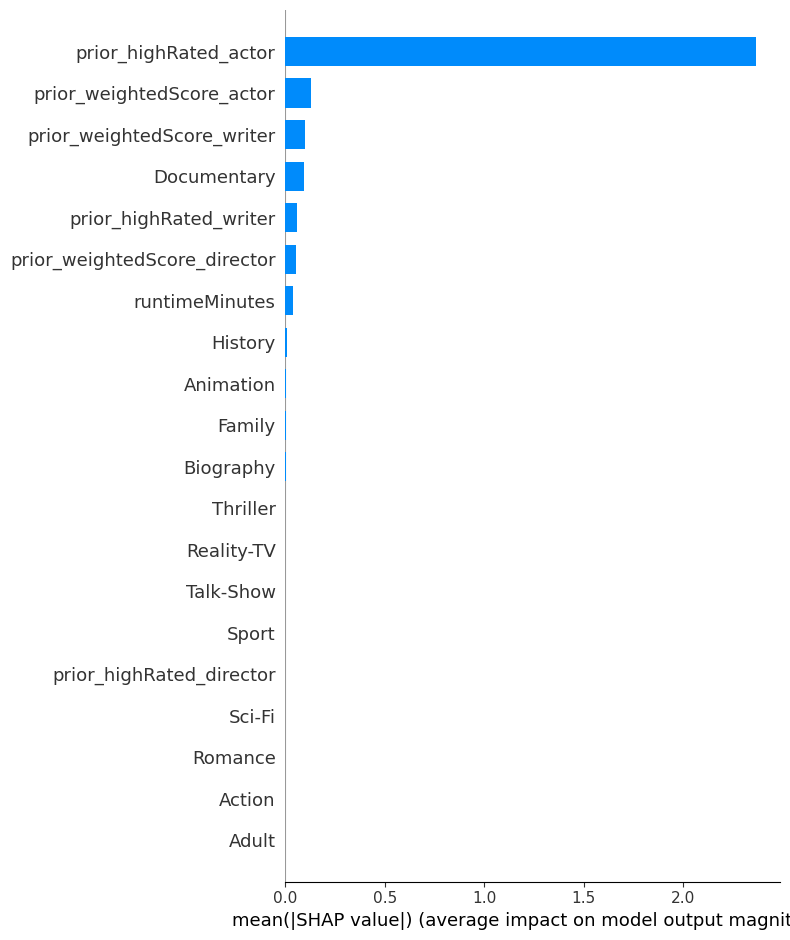

In [10]:
explainer = shap.TreeExplainer(model.named_steps['xgbclassifier'])
shap_values = explainer.shap_values(X_holdout, check_additivity=False)
shap.summary_plot(shap_values, X_holdout, plot_type='bar')


#### Key Insights from the Chart:
1. Top Features:
   - **prior_highRated_actor**: This feature has the highest SHAP value, meaning the presence of actors with a history of being part of high-rated movies significantly influences the model’s prediction of whether a movie is AAA. This makes sense, as the involvement of popular or acclaimed actors is a strong indicator of movie success.
   - **prior_weightedScore_writer**: Writers with a track record of high-scoring movies also play an important role, but their influence is much lower compared to actors.
   - **Documentary**: Whether the movie is a documentary also has a notable impact on the prediction. This could be due to a niche audience and scoring trends within this genre.
2. Moderately Important Features:
   - Features like **prior_weightedScore_director, prior_highRated_writer, and prior_weightedScore_actor** have moderate SHAP values, suggesting that the **director's and writer's past success also influence the prediction**, though less than actors.
3. Less Important Features:
   - Features such as **runtimeMinutes, History, and Biography** have smaller SHAP values, indicating minimal influence on the prediction.
Genres like Romance, Sci-Fi, and Sport have negligible SHAP values, meaning they do not significantly contribute to the model's prediction.

### XGBOOST PREDICTION WITH SHAP FORCE PLOT 

This image represents a SHAP force plot for a specific prediction made by an XGBoost model. A force plot explains the individual contributions of features to a model's prediction, relative to a baseline (or expected) value.

In [14]:
shap.initjs()

In [15]:
instance_index_label = 169775
instance_index = X_holdout.index.get_loc(instance_index_label)
shap.force_plot(
    explainer.expected_value, 
    shap_values[instance_index],  
    X_holdout.loc[instance_index_label], 
    feature_names=X_holdout.columns.tolist()
)


This chart shows how the feature **prior_highRated_actor affects the prediction** for whether this movie could be the next AAA title.

The **base value is about -0.00027**, which is the average prediction the model makes before looking at any features. The final prediction for this movie is **2.49**, and the main reason for this increase is the **feature prior_highRated_actor**, which is 13 here.

***What does that mean?*** 
- It means the actors in this movie have been in 13 highly rated films before.
- The model sees this as a very positive sign, because actors with strong track records often bring credibility and fan interest, which are key for predicting a movie’s success before release.
- So, in simple terms, the model predicts a high chance of success partly because of the strong cast involved in the movie.

In [18]:
# Save SHAP force plot as an HTML file
shap.save_html("force_plot.html", shap.force_plot(
    explainer.expected_value,
    shap_values[instance_index],  
    X_holdout.loc[instance_index_label],  
    feature_names=X_holdout.columns.tolist()
))

In [37]:
def predict_if_fraud(transaction_id):
    transaction = X_holdout.loc[transaction_id].values.reshape(1, -1)
    prediction_num = model.predict(transaction)[0]
    proba = model.predict_proba(transaction)[0]
    threshold = 0.5
    pred_proba = (proba[1] >= threshold).astype(int) 
    pred_map = {1: 'AAA', 0: 'Not AAA'}
    prediction = pred_map[prediction_num]
    return prediction, pred_proba

In [42]:
transaction_id = 119670 #169775
output, pred_proba = predict_if_fraud(transaction_id)

print(output,pred_proba)

Not AAA 0


### Future Improvements: Focus on Incorporating Graph Neural Networks (GNNs)

Graph Neural Networks (GNNs) offer a promising avenue for enhancing the predictive power of the XGBoost + SHAP framework, particularly in applications like predicting AAA movie titles where relational data is critical.

-------------------------------

**Why GNNs?**

GNNs are designed to model and learn from graph-structured data, where entities (nodes) and their relationships (edges) provide critical context. In the context of movie analytics, many features can be naturally represented as a graph, making GNNs an ideal choice for extracting deeper insights:
1. Actor Collaboration Networks: Relationships between actors who frequently work together may influence the success of a movie (e.g., "chemistry" between co-stars).
2. Genre Networks: Movies within the same genre often share similar audience preferences, trends, or marketing strategies.
4. Director-Actor Interactions: Certain director-actor pairings might have a history of successful projects, which could be a strong indicator of future success.


--------------------------------

**Integration with XGBoost**

Feature Augmentation: Use GNNs to generate node or edge embeddings (numerical representations of graph properties) for actors, directors, or movies.
Feed these embeddings as additional features into the XGBoost model to enhance predictions.